# **Importer les Bibliothèques et Initialiser Spark**

In [225]:
import sys
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns

In [226]:
spark = SparkSession.builder \
    .appName("Data Processing dans catalogue csv") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()
print("Session Spark initialisée avec succès.")


Session Spark initialisée avec succès.


# **Charger les données depuis le fichier Hive**


In [227]:
# Charger les données depuis Hive
spark.sql("USE concessionnaire")
catalogue_df = spark.sql("SELECT * FROM catalogue_table_processed")
co2_df = spark.sql("SELECT * FROM co2_data_processed")

# Vérifier les données chargées
print("Données Catalogue :")
catalogue_df.show(5)

print("Données CO2 :")
co2_df.show(5)

Données Catalogue :
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+
|    marque|    modele|modele_detail|unified_horse_power|   longueur|nbplaces|nbportes|couleur|occasion|    prix|
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+
|   Renault|    Espace|         2.0T|                165|     longue|       7|       5|  rouge|    true| 21245.0|
|Volkswagen|New Beatle|          1.8|                110|    moyenne|       5|       5|   gris|   false| 26630.0|
|       BMW|        M5|             |                507|très longue|       5|       5|   bleu|    true| 66360.0|
|    Nissan|    Maxima|       3.0 V6|                200|très longue|       5|       5|  rouge|   false| 30000.0|
|  Mercedes|      S500|             |                306|très longue|       5|       5|   noir|   false|101300.0|
+----------+----------+-------------+-------------------+-----------

# **Nettoyer l'Encodage et les Données**


In [228]:

# Nettoyer les colonnes numériques dans le DataFrame CO2
co2_df = co2_df.withColumn("bonus_malus", F.regexp_replace(F.col("bonus_malus"), r"[^\d\-,\.]", "").cast(FloatType()))
co2_df = co2_df.withColumn("rejets_co2", F.regexp_replace(F.col("rejets_co2"), r"[^\d\-,\.]", "").cast(FloatType()))
co2_df = co2_df.withColumn("cout_energie", F.regexp_replace(F.col("cout_energie"), r"[^\d\-,\.]", "").cast(FloatType()))

# Vérifier les données après nettoyage
print("Données CO2 après nettoyage :")
co2_df.select("marque", "modele", "bonus_malus", "rejets_co2", "cout_energie").show(10)

# Normaliser les colonnes de marque
co2_df = co2_df.withColumn("marque_norm", F.lower(F.trim(F.col("marque"))))
catalogue_df = catalogue_df.withColumn("marque_norm", F.lower(F.trim(F.col("marque"))))

Données CO2 après nettoyage :
+--------+--------+-----------+----------+------------+
|  marque|  modele|bonus_malus|rejets_co2|cout_energie|
+--------+--------+-----------+----------+------------+
| PEUGEOT|     ION|    -6000.0|       0.0|       241.0|
|   TESLA|   MODEL|    -6000.0|       0.0|       293.0|
|MERCEDES|SPRINTER|     6810.0|     178.0|       715.0|
|MERCEDES|SPRINTER|     8173.0|     183.0|       736.0|
|  NISSAN|   NV400|     8753.0|     200.0|       810.0|
|MERCEDES|SPRINTER|     8753.0|     237.0|       946.0|
|MERCEDES|SPRINTER|     7073.0|     179.0|       715.0|
|MERCEDES|SPRINTER|     8753.0|     200.0|       799.0|
|MERCEDES|    VITO|    -6000.0|       0.0|       411.0|
|   SMART|      EQ|    -6000.0|       0.0|       175.0|
+--------+--------+-----------+----------+------------+
only showing top 10 rows


# **Calculer les moyennes**


In [229]:
# Calculer les moyennes par marque pour remplir les données manquantes
averages_by_marque = co2_df.groupBy("marque_norm").agg(
    F.round(F.avg("bonus_malus"), 1).alias("avg_bonus_malus"),
    F.round(F.avg("rejets_co2"), 1).alias("avg_rejets_co2"),
    F.round(F.avg("cout_energie"), 1).alias("avg_cout_energie")
)

# Calculer les moyennes globales
overall_averages = co2_df.agg(
    F.round(F.avg("bonus_malus"), 1).alias("avg_bonus_malus"),
    F.round(F.avg("rejets_co2"), 1).alias("avg_rejets_co2"),
    F.round(F.avg("cout_energie"), 1).alias("avg_cout_energie")
).collect()[0]

# Afficher les moyennes calculées
print("Moyennes par marque :")
averages_by_marque.show()

print("\nMoyennes globales :")
print("Bonus/Malus : {}, Rejets CO2 : {}, Coût Énergie : {}".format(
    overall_averages["avg_bonus_malus"],
    overall_averages["avg_rejets_co2"],
    overall_averages["avg_cout_energie"]
))


Moyennes par marque :
+-----------+---------------+--------------+----------------+
|marque_norm|avg_bonus_malus|avg_rejets_co2|avg_cout_energie|
+-----------+---------------+--------------+----------------+
|     jaguar|        -6000.0|           0.0|           271.0|
| mitsubishi|           NULL|          40.0|            98.0|
|   mercedes|         8245.0|         189.8|           759.9|
|     toyota|           NULL|          32.0|            43.0|
|    peugeot|        -6000.0|          12.8|           159.6|
|         ds|        -6000.0|          16.5|           159.0|
|    citroen|        -6000.0|           0.0|           347.0|
|      tesla|        -6000.0|           0.0|           245.9|
|       audi|        -6000.0|          24.6|           206.9|
|        bmw|        -6000.0|          38.7|            83.7|
|    bentley|           NULL|          84.0|           102.0|
|      skoda|        -6000.0|          27.6|            98.9|
|    hyundai|        -6000.0|           8.7|    

# **Fusionner les Données**

In [230]:

# Jointure entre le catalogue et les données CO2 sur les colonnes normalisées
co2_df = co2_df.withColumn("modele_norm", F.lower(F.trim(F.col("modele"))))
catalogue_df = catalogue_df.withColumn("modele_norm", F.lower(F.trim(F.col("modele"))))

catalogue_with_co2 = catalogue_df.join(
    co2_df.select("marque_norm", "modele_norm", "bonus_malus", "rejets_co2", "cout_energie"),
    on=["marque_norm", "modele_norm"],
    how="left"
)

# Jointure avec les moyennes par marque
catalogue_with_co2 = catalogue_with_co2.join(
    averages_by_marque,
    on="marque_norm",
    how="left"
)

# Remplir les valeurs manquantes avec des moyennes
catalogue_with_co2 = catalogue_with_co2.withColumn(
    "bonus_malus_final",
    F.coalesce(
        F.col("bonus_malus"),
        F.col("avg_bonus_malus"),
        F.lit(overall_averages["avg_bonus_malus"])
    )
).withColumn(
    "rejets_co2_final",
    F.coalesce(
        F.col("rejets_co2"),
        F.col("avg_rejets_co2"),
        F.lit(overall_averages["avg_rejets_co2"])
    )
).withColumn(
    "cout_energie_final",
    F.coalesce(
        F.col("cout_energie"),
        F.col("avg_cout_energie"),
        F.lit(overall_averages["avg_cout_energie"])
    )
)

# **Vérifier les Données Fusionnées**

In [231]:
# Réorganiser les colonnes finales
final_columns = [col for col in catalogue_df.columns if col not in ["marque_norm", "modele_norm"]] + \
                ["bonus_malus_final", "rejets_co2_final", "cout_energie_final"]
catalogue_with_co2 = catalogue_with_co2.select(*final_columns)

# Renommer les colonnes finales pour enlever le suffixe '_final'
catalogue_with_co2 = catalogue_with_co2.withColumnRenamed("bonus_malus_final", "bonus_malus") \
    .withColumnRenamed("rejets_co2_final", "rejets_co2") \
    .withColumnRenamed("cout_energie_final", "cout_energie")

# Vérifier les résultats finaux
print("Données Catalogue fusionnées avec CO2 :")
catalogue_with_co2.show(10)

Données Catalogue fusionnées avec CO2 :
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+-----------+----------+------------+
|    marque|    modele|modele_detail|unified_horse_power|   longueur|nbplaces|nbportes|couleur|occasion|    prix|bonus_malus|rejets_co2|cout_energie|
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+-----------+----------+------------+
|   Renault|    Espace|         2.0T|                165|     longue|       7|       5|  rouge|    true| 21245.0|    -6000.0|       0.0|       206.0|
|Volkswagen|New Beatle|          1.8|                110|    moyenne|       5|       5|   gris|   false| 26630.0|    -6000.0|      13.3|       149.3|
|       BMW|        M5|             |                507|très longue|       5|       5|   bleu|    true| 66360.0|    -6000.0|      38.7|        83.7|
|    Nissan|    Maxima|       3.0 V6|                200|trè

# **Enregistrer les Données Fusionnées**

In [232]:
# Enregistrer les données dans Hive
catalogue_with_co2.write.mode("overwrite").saveAsTable("catalogue_co2_merge_processed")
print("Données fusionnées enregistrées avec succès.")

Données fusionnées enregistrées avec succès.


# **Analyser les Données Fusionnées**

In [233]:
catalogue_with_co2.describe(["prix", "rejets_co2", "unified_horse_power", "longueur", "nbplaces"]).show()

# Vérification des véhicules avec rejets CO2 = 0
zero_co2_vehicles = catalogue_with_co2.filter(F.col("rejets_co2") == 0)

# Compter le nombre total de véhicules avec rejets CO2 = 0
zero_co2_count = zero_co2_vehicles.count()
total_vehicles = catalogue_with_co2.count()

# Compter les véhicules avec rejets CO2 = 0 et un malus
zero_co2_malus_count = zero_co2_vehicles.filter(F.col("bonus_malus") < 0).count()

# Calculer les proportions
zero_co2_proportion = zero_co2_count / total_vehicles * 100
zero_co2_malus_proportion = zero_co2_malus_count / zero_co2_count * 100 if zero_co2_count > 0 else 0

# Afficher les résultats
print(f"Nombre total de véhicules : {total_vehicles}")
print(f"Nombre de véhicules avec rejets CO2 = 0 : {zero_co2_count}")
print(f"Proportion de véhicules avec rejets CO2 = 0 : {zero_co2_proportion:.2f}%")
print(f"Nombre de véhicules avec rejets CO2 = 0 et malus : {zero_co2_malus_count}")
print(f"Proportion des véhicules avec rejets CO2 = 0 et malus : {zero_co2_malus_proportion:.2f}%")

# Afficher les détails des incohérences
print("Détails des véhicules avec rejets CO2 = 0 et malus :")
zero_co2_vehicles.filter(F.col("bonus_malus") < 0).select(
    "marque", "modele", "rejets_co2", "bonus_malus", "prix"
).show()



# Identifier les véhicules avec rejets CO2 = 0
zero_co2_vehicles = catalogue_with_co2.filter(F.col("rejets_co2") == 0)

# Vérifier les marques concernées
zero_co2_vehicles.groupBy("marque").count().show()

# Détail des modèles avec rejets CO2 = 0 et malus
zero_co2_malus_vehicles = zero_co2_vehicles.filter(F.col("bonus_malus") < 0)
zero_co2_malus_vehicles.select("marque", "modele", "rejets_co2", "bonus_malus").show(100)



+-------+------------------+-----------------+-------------------+-----------+------------------+
|summary|              prix|       rejets_co2|unified_horse_power|   longueur|          nbplaces|
+-------+------------------+-----------------+-------------------+-----------+------------------+
|  count|              2835|             2835|               2835|       2835|              2835|
|   mean| 27008.47619047619|67.25714285714285| 161.28571428571428|       NULL| 5.190476190476191|
| stddev|17743.823601896613|68.12343642966783|  84.45204794471628|       NULL|0.5871906179913317|
|    min|            7500.0|              0.0|                 55|     courte|                 5|
|    max|          101300.0|            189.8|                507|très longue|                 7|
+-------+------------------+-----------------+-------------------+-----------+------------------+
Nombre total de véhicules : 2835
Nombre de véhicules avec rejets CO2 = 0 : 450
Proportion de véhicules avec rejets CO2

# **Données manquantes**

In [234]:
from pyspark.sql.functions import col, sum, when
null_counts = co2_df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in co2_df.columns])
null_counts.show()


+------+------+-------------+-----------+----+-------------------+-----------+------------+----------+-----------+-----------+
|marque|modele|modele_detail|horse_power|unit|unified_horse_power|bonus_malus|cout_energie|rejets_co2|marque_norm|modele_norm|
+------+------+-------------+-----------+----+-------------------+-----------+------------+----------+-----------+-----------+
|     0|     0|            0|         62|   0|                 62|         79|           0|         0|          0|          0|
+------+------+-------------+-----------+----+-------------------+-----------+------------+----------+-----------+-----------+


# **Distribution des Prix des Véhicules**

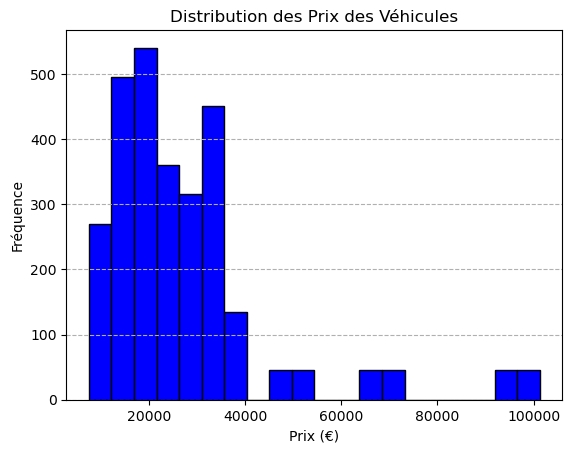

In [235]:
prices = catalogue_with_co2.select("prix").rdd.flatMap(lambda x: x).collect()
plt.hist(prices, bins=20, color='blue', edgecolor='black')
plt.xlabel("Prix (€)")
plt.ylabel("Fréquence")
plt.title("Distribution des Prix des Véhicules")
plt.grid(axis='y', linestyle='--')
plt.show()


La majorité des véhicules ont un prix situé entre 20 000 € et 40 000 €, avec un pic autour de 25 000 €. Les véhicules de plus de 60 000 € sont peu nombreux, ce qui montre une distribution asymétrique centrée sur des véhicules de milieu de gamme.

# **Distribution de la Puissance des Véhicules**

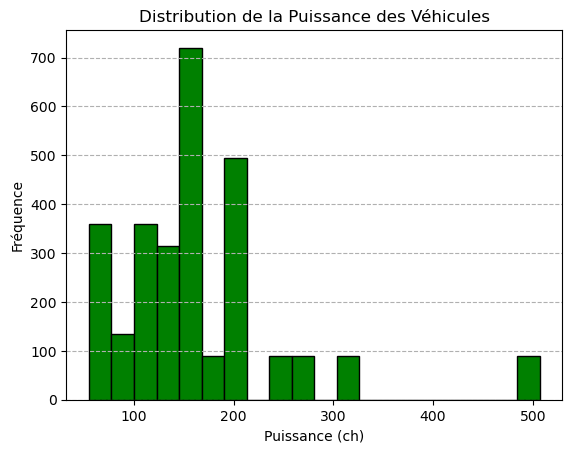

In [236]:
horsepower_data = catalogue_with_co2.select("unified_horse_power").rdd.flatMap(lambda x: x).collect()
plt.hist(horsepower_data, bins=20, color='green', edgecolor='black')
plt.xlabel("Puissance (ch)")
plt.ylabel("Fréquence")
plt.title("Distribution de la Puissance des Véhicules")
plt.grid(axis='y', linestyle='--')
plt.show()


La majorité des véhicules ont une puissance comprise entre 100 ch et 200 ch, avec un pic autour de 150 ch. Les véhicules de plus de 300 ch sont rares, ce qui indique une concentration sur des voitures de puissance moyenne.

# **Répartition des Marques**

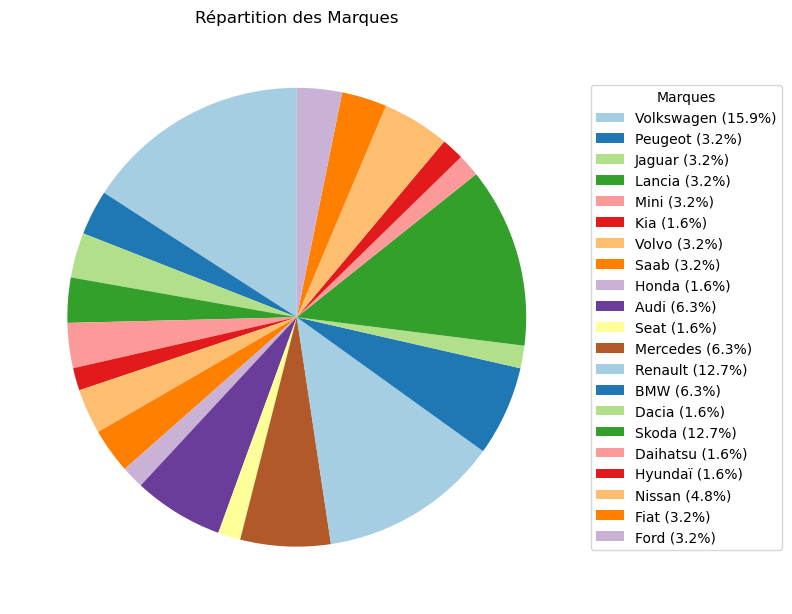

In [237]:
brand_distribution = catalogue_with_co2.groupBy("marque").count().toPandas()
brand_distribution["percentage"] = (brand_distribution["count"] / brand_distribution["count"].sum()) * 100

plt.figure(figsize=(8, 8))
plt.pie(brand_distribution["count"], startangle=90, colors=plt.cm.Paired.colors)
labels = [f"{row['marque']} ({row['percentage']:.1f}%)" for _, row in brand_distribution.iterrows()]
plt.legend(labels, title="Marques", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title("Répartition des Marques")
plt.tight_layout()
plt.show()


# **Matrice de Corrélation**

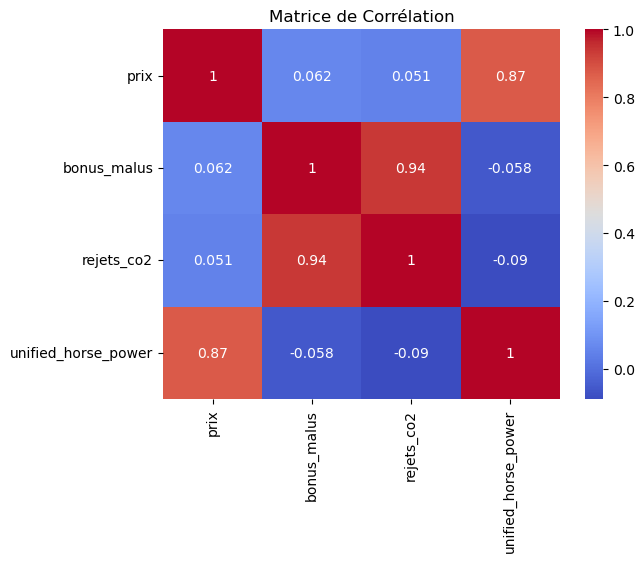

In [238]:
correlations = catalogue_with_co2.select("prix", "bonus_malus", "rejets_co2", "unified_horse_power").toPandas().corr()
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.title("Matrice de Corrélation")
plt.show()


Le prix est fortement corrélé à la puissance unifiée des véhicules (0.87), ce qui est attendu pour des voitures plus puissantes.
Les rejets de CO₂ sont très fortement corrélés au bonus/malus (0.94), reflétant leur impact direct sur la taxe écologique.
La puissance unifiée a une très faible corrélation négative avec les rejets de CO₂ (-0.09), probablement dû à la présence de véhicules électriques ou hybrides puissants mais peu polluants.

# **Relation entre Puissance et Prix**

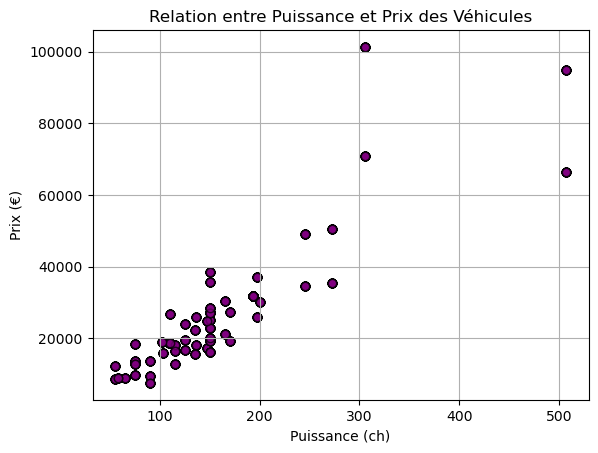

In [239]:
price_hp_data = catalogue_with_co2.select("prix", "unified_horse_power").rdd.map(tuple).collect()
prices, hp = zip(*price_hp_data)
plt.scatter(hp, prices, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel("Puissance (ch)")
plt.ylabel("Prix (€)")
plt.title("Relation entre Puissance et Prix des Véhicules")
plt.grid(True)
plt.show()


Le prix des véhicules augmente généralement avec la puissance, avec une tendance claire pour les puissances jusqu'à 200 ch. Cependant, au-delà de 300 ch, les prix varient fortement, reflétant la diversité des segments de véhicules, notamment les modèles haut de gamme

# **Relation entre Rejets CO2 et Bonus/Malus**

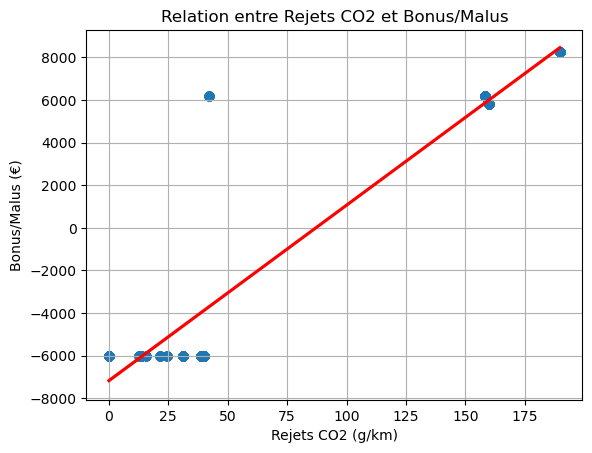

In [240]:
df_pandas = catalogue_with_co2.select("rejets_co2", "bonus_malus").toPandas()
sns.regplot(x="rejets_co2", y="bonus_malus", data=df_pandas, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.xlabel("Rejets CO2 (g/km)")
plt.ylabel("Bonus/Malus (€)")
plt.title("Relation entre Rejets CO2 et Bonus/Malus")
plt.grid(True)
plt.show()


Une relation linéaire claire existe entre les rejets de CO₂ et le bonus/malus. Les véhicules avec des émissions élevées subissent un malus (valeurs négatives), tandis que ceux avec des émissions très faibles bénéficient d'un bonus (valeurs positives).

# **Analyse des Bonus/Malus**

+--------------------+-----+
|bonus_malus_category|count|
+--------------------+-----+
|               Bonus|  990|
|               Malus| 1845|
+--------------------+-----+


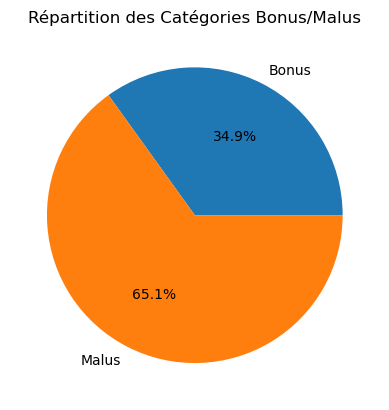

In [241]:
co2_df = catalogue_with_co2.withColumn("bonus_malus_category", 
    F.when(F.col("bonus_malus") > 0, "Bonus")
    .when(F.col("bonus_malus") < 0, "Malus")
    .otherwise("Neutre ou Inconnu"))

co2_df.groupBy("bonus_malus_category").count().show()

# Visualisation
bonus_dist = co2_df.groupBy("bonus_malus_category").count().toPandas()
plt.pie(bonus_dist["count"], labels=bonus_dist["bonus_malus_category"], autopct="%1.1f%%")
plt.title("Répartition des Catégories Bonus/Malus")
plt.show()


# **Analyse des Marques**

In [242]:
catalogue_with_co2.groupBy("marque").agg(F.avg("unified_horse_power").alias("avg_hp")).orderBy(F.desc("avg_hp")).show(10)


+--------+------------------+
|  marque|            avg_hp|
+--------+------------------+
|     BMW|             328.5|
|   Volvo|             272.0|
|Mercedes|             221.0|
|  Jaguar|             197.0|
|   Skoda|             193.0|
| Renault|            178.75|
|    Saab|             150.0|
|    Fiat|             147.0|
|  Nissan|141.33333333333334|
|   Honda|             125.0|
+--------+------------------+


# **Valeurs aberrantes**

In [243]:
from pyspark.sql.functions import mean, stddev

stats = catalogue_with_co2.select(mean("unified_horse_power").alias("mean"), stddev("unified_horse_power").alias("stddev")).first()
mean_hp, stddev_hp = stats["mean"], stats["stddev"]

outliers = catalogue_with_co2.filter(
    (F.col("unified_horse_power") > mean_hp + 3 * stddev_hp) |
    (F.col("unified_horse_power") < mean_hp - 3 * stddev_hp)
)
print(f"Nombre de valeurs aberrantes : {outliers.count()}")
outliers.select("marque", "modele", "unified_horse_power", "prix").show()


Nombre de valeurs aberrantes : 90
+------+------+-------------------+-------+
|marque|modele|unified_horse_power|   prix|
+------+------+-------------------+-------+
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|66360.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|94800.0|
|   BMW|    M5|                507|94800.0

Parmi les valeurs aberrantes, on observe des véhicules comme la BMW M5, qui combine une puissance très élevée (507 ch) avec des prix particulièrement élevés (>60 000 €). Ces valeurs reflètent des modèles de luxe ou de performance qui se situent bien au-delà de la moyenne des données.

In [244]:
# Ajouter une colonne de catégorie personnalisée
co2_df = co2_df.withColumn(
    "categorie_vehicule",
    F.when(
        (F.col("prix") < 20000) & 
        (F.col("unified_horse_power") < 100) & 
        (F.col("rejets_co2") < 50) & 
        (F.col("bonus_malus") >= 0),
        "Petite voiture économique"
    ).when(
        (F.col("longueur") > 4.5) & 
        (F.col("nbplaces") >= 5) & 
        (F.col("prix").between(30000, 50000)) & 
        (F.col("unified_horse_power").between(150, 250)) & 
        (F.col("rejets_co2").between(50, 150)),
        "SUV familial"
    ).when(
        (F.col("prix") > 50000) & 
        (F.col("unified_horse_power") > 300) & 
        (F.col("rejets_co2") > 150) & 
        (F.col("longueur") > 4.8),
        "Voiture de luxe ou de sport"
    ).when(
        (F.col("unified_horse_power") > 200) & 
        (F.col("rejets_co2") < 50) & 
        (F.col("bonus_malus") > 0) & 
        (F.col("prix") > 40000),
        "Hybride ou électrique haut de gamme"
    ).when(
        (F.col("prix").between(20000, 40000)) & 
        (F.col("unified_horse_power").between(100, 200)) & 
        (F.col("rejets_co2").between(50, 150)),
        "Véhicule polyvalent standard"
    ).when(
        (F.col("prix") > 80000) & 
        (F.col("unified_horse_power") > 400) & 
        (F.col("rejets_co2") > 150),
        "Véhicule ultra-sportif"
    ).when(
        (F.col("prix") < 30000) & 
        (F.col("unified_horse_power") < 150) & 
        (F.col("rejets_co2") < 50) & 
        (F.col("bonus_malus") > 0),
        "Véhicule éco-responsable entrée de gamme"
    ).otherwise("Non catégorisé")  # Catégorie par défaut si aucun critère n'est rempli
)

# Afficher quelques exemples pour vérifier les catégories
co2_df.select("marque", "modele", "prix", "unified_horse_power", "rejets_co2", "bonus_malus", "categorie_vehicule").show(200)


+----------+----------+--------+-------------------+----------+-----------+--------------------+
|    marque|    modele|    prix|unified_horse_power|rejets_co2|bonus_malus|  categorie_vehicule|
+----------+----------+--------+-------------------+----------+-----------+--------------------+
|   Renault|    Espace| 21245.0|                165|       0.0|    -6000.0|      Non catégorisé|
|Volkswagen|New Beatle| 26630.0|                110|      13.3|    -6000.0|      Non catégorisé|
|       BMW|        M5| 66360.0|                507|      38.7|    -6000.0|      Non catégorisé|
|    Nissan|    Maxima| 30000.0|                200|     160.0|     5802.4|      Non catégorisé|
|  Mercedes|      S500|101300.0|                306|     189.8|     8245.0|      Non catégorisé|
|Volkswagen|New Beatle| 26630.0|                110|      13.3|    -6000.0|      Non catégorisé|
|  Mercedes|      S500|101300.0|                306|     189.8|     8245.0|      Non catégorisé|
|Volkswagen|    Touran| 19138.

# **Fermer la session Spark**


In [245]:
# Arrêter la session Spark
# spark.stop()